In [38]:
import pandas as pd
import pickle # Add this line to import the JSON module
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#import tensorflowjs as tfjs

In [39]:
data = pd.read_csv('spam.csv', encoding='latin-1')

In [40]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [42]:
data = data[['v1', 'v2']]  
data.columns = ['label', 'text']

In [43]:
data.sample(5)

,label,text
715,ham,When i have stuff to sell i.ll tell you
1895,ham,"Uh, heads up we don't have THAT much left"
2245,ham,How did you find out in a way that didn't incl...
4754,ham,U wan 2 haf lunch i'm in da canteen now.
3562,spam,Auction round 4. The highest bid is now å£54. ...


In [44]:
data.dropna(subset=['label', 'text'], inplace=True)

C:\Users\RAMESH MAITY\AppData\Local\Temp\ipykernel_14960\3602966412.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=['label', 'text'], inplace=True)


In [45]:
data['label'] = data['label'].map({'spam': 1, 'ham': 0})

In [46]:
data.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


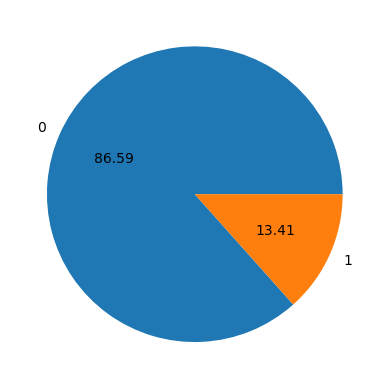

In [47]:
import matplotlib.pyplot as plt
plt.pie(data['label'].value_counts(), labels=[0,1],autopct="%0.2f")
plt.show()

In [48]:
X = data['text']
y = data['label']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
max_words = 5000
max_len = 100

In [51]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [52]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [53]:
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [ ]:
file = open('tokenizer.pkl','wb')
pickle.dump(tokenizer , file)
file.close()

In [54]:
# Build the model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [55]:
model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test), verbose=2)

Epoch 1/5
70/70 - 13s - 193ms/step - accuracy: 0.9269 - loss: 0.2282 - val_accuracy: 0.9749 - val_loss: 0.0917
Epoch 2/5
70/70 - 6s - 92ms/step - accuracy: 0.9863 - loss: 0.0496 - val_accuracy: 0.9821 - val_loss: 0.0674
Epoch 3/5
70/70 - 7s - 94ms/step - accuracy: 0.9933 - loss: 0.0240 - val_accuracy: 0.9830 - val_loss: 0.0613
Epoch 4/5
70/70 - 6s - 92ms/step - accuracy: 0.9957 - loss: 0.0153 - val_accuracy: 0.9830 - val_loss: 0.0568
Epoch 5/5
70/70 - 6s - 90ms/step - accuracy: 0.9978 - loss: 0.0078 - val_accuracy: 0.9839 - val_loss: 0.0530


In [59]:
model.save("model_spam.keras")

In [56]:
# Evaluate the model
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Accuracy: 0.9838565022421525
Confusion Matrix:
 [[962   3]
 [ 15 135]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.98      0.90      0.94       150

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [57]:
# Function to detect spam
def is_spam(email):
    email_seq = tokenizer.texts_to_sequences([email])
    email_pad = pad_sequences(email_seq, maxlen=max_len)
    prediction = model.predict(email_pad)
    return "Spam" if prediction[0][0] > 0.5 else "Not Spam"

In [58]:
new_email = "Congratulations! You've won a free ticket to the Bahamas."
print(f"The email is: {is_spam(new_email)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
The email is: Spam
